In [ ]:
import numpy as np
import pandas as pd
df_sample=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\sample.csv")

In [ ]:
df_sample = df_sample.reset_index(drop=True)

In [ ]:
df_sample

## Feature encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['type'])
label
df_sample.drop("type", axis=1, inplace=True)
df_sample["type"] = label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['nameDest'])
label
df_sample.drop("nameDest", axis=1, inplace=True)
df_sample["nameDest"] = label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['nameOrig'])
label
df_sample.drop("nameOrig", axis=1, inplace=True)
df_sample["nameOrig"] = label

## Train test split

In [ ]:
from sklearn.model_selection import train_test_split

X = df_sample.drop('isFraud', axis=1)
# Separate the target variable
y = df_sample['isFraud']

# Print class distribution before split
print(y.value_counts(normalize=True))

from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=2)

# Print class distribution after split
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

## Class imbalance

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Upsampling via SMOTE
smote = SMOTE(sampling_strategy=0.2, random_state=0)

#Downsample via RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.4, random_state=0)

#Application of the resampling methods
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

## Noisy samples

In [ ]:
from imblearn.under_sampling import TomekLinks

#Resample using TomekLinks first
tomek_links = TomekLinks(sampling_strategy='majority')
X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_resampled, y_resampled)

In [ ]:
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours,OneSidedSelection
# resample the output of TomekLinks using EditedNearestNeighbours
enn = EditedNearestNeighbours(sampling_strategy='majority')
X_train_resampled_new, y_train_resampled_new = enn.fit_resample(X_train_resampled, y_train_resampled)

In [ ]:
from imblearn.under_sampling import OneSidedSelection
# resample the output of EditedNearestNeighbours using One-Sided Selection
oss = OneSidedSelection(sampling_strategy='majority')
X_train_resampled_final, y_train_resampled_final = oss.fit_resample(X_train_resampled_new, y_train_resampled_new)

In [ ]:
# # flatten the array using the ravel function
# y_train_resampled_final_flattened = np.ravel(y_train_resampled_final)

# counts = np.bincount(y_train_resampled_final_flattened)
# print("Class 0 count:", counts[0])
# print("Class 1 count:", counts[1])

## Outliers

In [ ]:
import random
import numpy as np
from scipy import stats

random.seed(0)
# Specify columns with outliers
cols_with_outliers = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Specify the number of bootstrapped samples to create per column
num_samples = 50

# Specify the right trimming proportions for each column
trim_props = {'amount': 0.01, 'oldbalanceOrg': 0.07, 'newbalanceOrig': 0.015, 'oldbalanceDest': 0.015, 'newbalanceDest': 0.01}

# Initialize empty dictionaries to store the trimmed means for each column
train_trimmed_means = {}

# Loop over the specified columns
for col_name in cols_with_outliers:
    
    # Check if the trimming proportion for this column is 0
    if trim_props[col_name] == 0:
        # If so, skip this column and move on to the next one
        continue
    
    # Initialize empty lists to store the bootstrapped samples and the trimmed means for the training set
    train_bootstrapped_samples = []
    train_trimmed_means_list = []
    
    # Loop over the number of desired samples
    for i in range(num_samples):
        # Randomly select indices from the column in the training set
        train_sample_indices = np.random.choice(X_train_resampled_final.index, size=len(X_train_resampled_final), replace=True)
        
        # Create a bootstrapped sample by indexing into the column with the selected indices for the training set
        train_sample = X_train_resampled_final.loc[train_sample_indices, col_name]
        
        # Append the bootstrapped samples to the list for the training set
        train_bootstrapped_samples.append(train_sample)
        
        # Calculate the right trimmed mean of the bootstrapped sample for the training set
        train_right_trimmed_mean = np.mean(train_sample[train_sample <= np.percentile(train_sample, 100*(1-trim_props[col_name]))])
        train_trimmed_means_list.append(train_right_trimmed_mean)
        
    # Calculate the mean of the right trimmed means for the training set and add it to the dictionary
    train_trimmed_means[col_name] = np.mean(train_trimmed_means_list)

    # Replace the outliers in the training set with the trimmed means
    X_train_resampled_final.loc[X_train_resampled_final[col_name] > np.percentile(X_train_resampled_final[col_name], 100*(1-trim_props[col_name])), col_name] = train_trimmed_means[col_name]
    
    # Replace the outliers in the test set with the trimmed means obtained from the train set
    test_outliers = X_test.loc[X_test[col_name] > np.percentile(X_test[col_name], 100*(1-trim_props[col_name])), col_name]
    X_test.loc[test_outliers.index, col_name] = train_trimmed_means[col_name]
    
# Print the trimmed means for each column separately for the training set
print("Train set trimmed means: ", train_trimmed_means)

## Scale train data

In [ ]:
# import module
from sklearn.preprocessing import StandardScaler

# compute required values
scaler = StandardScaler()
model = scaler.fit(X_train_resampled_final)
X_train_resampled_final = model.transform(X_train_resampled_final)

## Scale test data

In [ ]:
# compute required values
scaler = StandardScaler()
model = scaler.fit(X_test)
X_test = model.transform(X_test)

In [ ]:
X_train_resampled_final

## GOOD ONE

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

# create the autoencoder
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 20

input_layer = Input(shape=(input_dim,))
hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)
output_layer = Dense(input_dim, activation='sigmoid')(hidden_layer)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train_resampled_final, X_train_resampled_final, epochs=1, batch_size=32)

# create a new model that outputs the hidden layer
hidden_layer_output = autoencoder.layers[1].output
hidden_layer_model = Model(inputs=autoencoder.input, outputs=hidden_layer_output)

# get the hidden layer output for a sample
sample_hidden_output = hidden_layer_model.predict(X_train_resampled_final[0].reshape(1, -1))
print(sample_hidden_output)

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

# create the autoencoder
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 20
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)
output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train_resampled_final, X_train_resampled_final, epochs=1, batch_size=32)

# extract hidden layer output from autoencoder
hidden_layer_output = autoencoder.layers[1].output

# create the mediator network with the hidden layer output as input
mediator_input_layer = Input(shape=hidden_layer_output.shape[1:])
mediator_hidden_layer = Dense(11, activation='relu')(mediator_input_layer)
mediator_output_layer = Dense(2, activation='sigmoid')(mediator_hidden_layer)

mediator_network = Model(inputs=mediator_input_layer, outputs=mediator_output_layer)
mediator_network.compile(optimizer='adam', loss='mse')
mediator_network.fit(hidden_layer_model.predict(X_train_resampled_final), y_train_resampled_final, epochs=1, batch_size=32)

# extract hidden layer output from mediator network
agent_hidden_layer_output = mediator_network.layers[1].output

agent_input_layer = Input(shape=agent_hidden_layer_output.shape[1:])
agent_hidden_layer = Dense(5, activation='relu')(agent_input_layer)
agent_output_layer = Dense(2, activation='softmax')(agent_hidden_layer)

agent_network = Model(inputs=agent_input_layer, outputs=agent_output_layer)
agent_network.compile(optimizer='adam', loss='categorical_crossentropy')

In [ ]:
autoencoder.summary()

In [ ]:
mediator_network.summary()

In [ ]:
agent_network.summary()

## Agent training

In [ ]:
class ReplayBuffer():
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = []
    
    def add(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)
        if len(self.buffer) > self.max_size:
            self.buffer.pop(0)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size), size=batch_size, replace=False)
        return [self.buffer[i] for i in index]
    
    def __len__(self):
        return len(self.buffer)

In [ ]:
# def REWARD(action, label, fraud_class='DF', non_fraud_class='DN', reward_fraud=1, reward_non_fraud=0.5, penalty=-1):
#     terminal = 0
#     if label == fraud_class:
#         if action == label:
#             reward = reward_fraud
#         else:
#             reward = penalty
#             terminal = 1
#     else:
#         if action == label:
#             reward = reward_non_fraud
#         else:
#             reward = penalty * reward_non_fraud
#     return reward, terminal

def REWARD(action, label, lambda_val, is_fraud):
    """
    Calculates the reward for a given action and label.
    
    Parameters:
    - action: The action taken by the agent.
    - label: The true label of the transaction.
    - lambda_val: The reward value when the agent correctly classifies a non-fraudulent transaction.
    - is_fraud: A boolean value indicating whether the transaction is fraudulent or not.
    
    Returns:
    - reward: The reward value.
    - terminal: A boolean indicating whether the episode is over or not.
    """
    if is_fraud:
        if action == label:
            reward = 1
        else:
            reward = -1
            terminal = True
    else:
        if action == label:
            reward = lambda_val
        else:
            reward = -lambda_val
        terminal = False
    
    return reward, terminal

In [ ]:
import numpy as np

input_shape = X_train_resampled_final.shape[1]
output_shape =X_train_resampled_final.shape[1]

# Set hyperparameters
gamma = 0.99
epsilon = 1
epsilon_decay = 0.9999
epsilon_min = 0.01
batch_size = 32
num_episodes = 2

# Initialize replay memory D with M capacity
M = 10000
replay_memory = ReplayBuffer(M)

# Randomly initialize parameters θ
theta_agent = np.random.normal(0, 0.1, size=(input_shape, output_shape))

# Loop over episodes
for episode in range(num_episodes):

    # Shuffle D
    np.random.shuffle(replay_memory.buffer)


    # Initialize state s1
    state = X_train_resampled_final[0]

    # Reset the episode
    total_reward = 0
    done = False
    t = 0

    # Loop over time steps
    while not done:

        # Choose an action: at = πθ(st)
        if np.random.rand() < epsilon:
            action = np.random.choice(output_shape)
        else:
            q_values = Q(state, theta_agent)
            action = np.argmax(q_values)

        # Take the action and observe the next state and reward
        next_state = X_train_resampled_final[t+1]
        reward, terminal = REWARD(action, y[t+1])

        # Store (st, at, rt, st+1, terminalt) to M
        replay_memory.add(state, action, reward, next_state, terminal)

        # Randomly sample (sj, aj, rj, sj+1, terminalj) from M
        batch = replay_memory.sample(batch_size)

        # Set yj
        y = np.zeros(batch_size)
        next_state_q_values = np.zeros(batch_size)
        for i in range(batch_size):
            if batch['terminal'][i]:
                y[i] = batch['reward'][i]
            else:
                next_state_q_values[i] = Q(batch['next_state'][i], theta_agent)
                y[i] = batch['reward'][i] + gamma * np.max(next_state_q_values[i])

        # Perform a gradient descent step
        loss = agent_loss(batch['state'], batch['action'], y, theta_agent)
        theta_agent -= 0.001 * loss

        # Update the state and total reward
        state = next_state
        total_reward += reward
        t += 1

        # Break if the episode is done
        if terminal:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Print the total reward for the episode
    print('Episode', episode + 1, '- Total Reward:', total_reward)

reward, terminal = REWARD(action, y[t+1], lambda_val, X[t+1][-1])

# Trial 2

In [5]:
import numpy as np
import pandas as pd
df_sample=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\sample.csv")

In [6]:
df_sample = df_sample.reset_index(drop=True)

## Feature encoding

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['type'])
label
df_sample.drop("type", axis=1, inplace=True)
df_sample["type"] = label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['nameDest'])
label
df_sample.drop("nameDest", axis=1, inplace=True)
df_sample["nameDest"] = label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['nameOrig'])
label
df_sample.drop("nameOrig", axis=1, inplace=True)
df_sample["nameOrig"] = label

In [8]:
import pandas as pd

# assuming df is your dataframe
new_order = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'type', 'nameDest', 'nameOrig', 'isFraud']

# create a new dataframe with columns in the desired order
df_sample = df_sample.drop(columns=['isFraud']).assign(isFraud=df_sample['isFraud'])

# check that the new dataframe has columns in the desired order
print(df_sample.columns.tolist())

['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'type', 'nameDest', 'nameOrig', 'isFraud']


## Split

In [9]:
# X_train_resampled_final = df_sample.iloc[:, :10] # extract all rows and first 10 columns
# y_train_resampled_final = df_sample.iloc[:, -1] # extract last column of entire dataframe

In [10]:
from sklearn.model_selection import train_test_split

X = df_sample.drop('isFraud', axis=1)
# Separate the target variable
y = df_sample['isFraud']

# Print class distribution before split
print(y.value_counts(normalize=True))

from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=2)

# Print class distribution after split
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.998743
1    0.001257
Name: isFraud, dtype: float64
0    0.998743
1    0.001257
Name: isFraud, dtype: float64
0    0.998743
1    0.001257
Name: isFraud, dtype: float64


In [11]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Upsampling via SMOTE
smote = SMOTE(sampling_strategy=0.2, random_state=0)

#Downsample via RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.4, random_state=0)

#Application of the resampling methods
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

In [12]:
from imblearn.under_sampling import TomekLinks

#Resample using TomekLinks first
tomek_links = TomekLinks(sampling_strategy='majority')
X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_resampled, y_resampled)

In [13]:
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours,OneSidedSelection
# resample the output of TomekLinks using EditedNearestNeighbours
enn = EditedNearestNeighbours(sampling_strategy='majority')
X_train_resampled_new, y_train_resampled_new = enn.fit_resample(X_train_resampled, y_train_resampled)

In [14]:
from imblearn.under_sampling import OneSidedSelection
# resample the output of EditedNearestNeighbours using One-Sided Selection
oss = OneSidedSelection(sampling_strategy='majority')
X_train_resampled_final, y_train_resampled_final = oss.fit_resample(X_train_resampled_new, y_train_resampled_new)

## Treat outliers on features

In [15]:
import random
import numpy as np
from scipy import stats

random.seed(0)
# Specify columns with outliers
cols_with_outliers = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Specify the number of bootstrapped samples to create per column
num_samples = 50

# Specify the right trimming proportions for each column
trim_props = {'amount': 0.01, 'oldbalanceOrg': 0.07, 'newbalanceOrig': 0.015, 'oldbalanceDest': 0.015, 'newbalanceDest': 0.01}

# Initialize empty dictionaries to store the trimmed means for each column
train_trimmed_means = {}

# Loop over the specified columns
for col_name in cols_with_outliers:
    
    # Check if the trimming proportion for this column is 0
    if trim_props[col_name] == 0:
        # If so, skip this column and move on to the next one
        continue
    
    # Initialize empty lists to store the bootstrapped samples and the trimmed means for the training set
    train_bootstrapped_samples = []
    train_trimmed_means_list = []
    
    # Loop over the number of desired samples
    for i in range(num_samples):
        # Randomly select indices from the column in the training set
        train_sample_indices = np.random.choice(X_train_resampled_final.index, size=len(X_train_resampled_final), replace=True)
        
        # Create a bootstrapped sample by indexing into the column with the selected indices for the training set
        train_sample = X_train_resampled_final.loc[train_sample_indices, col_name]
        
        # Append the bootstrapped samples to the list for the training set
        train_bootstrapped_samples.append(train_sample)
        
        # Calculate the right trimmed mean of the bootstrapped sample for the training set
        train_right_trimmed_mean = np.mean(train_sample[train_sample <= np.percentile(train_sample, 100*(1-trim_props[col_name]))])
        train_trimmed_means_list.append(train_right_trimmed_mean)
        
    # Calculate the mean of the right trimmed means for the training set and add it to the dictionary
    train_trimmed_means[col_name] = np.mean(train_trimmed_means_list)

    # Replace the outliers in the training set with the trimmed means
    X_train_resampled_final.loc[X_train_resampled_final[col_name] > np.percentile(X_train_resampled_final[col_name], 100*(1-trim_props[col_name])), col_name] = train_trimmed_means[col_name]
    
    # Replace the outliers in the test set with the trimmed means obtained from the train set
    test_outliers = X_test.loc[X_test[col_name] > np.percentile(X_test[col_name], 100*(1-trim_props[col_name])), col_name]
    X_test.loc[test_outliers.index, col_name] = train_trimmed_means[col_name]
    
# Print the trimmed means for each column separately for the training set
print("Train set trimmed means: ", train_trimmed_means)

Train set trimmed means:  {'amount': 597035.5249209261, 'oldbalanceOrg': 413385.27893655753, 'newbalanceOrig': 437712.35027510877, 'oldbalanceDest': 717787.2119580305, 'newbalanceDest': 1071875.2093536367}


## Scale data

In [16]:
# import module
from sklearn.preprocessing import StandardScaler

# compute required values
scaler = StandardScaler()
model = scaler.fit(X_train_resampled_final)
X_train_resampled_final = model.transform(X_train_resampled_final)

model = scaler.fit(X_test)
X_test = model.transform(X_test)

In [17]:
from keras.layers import Input, Dense
from keras.models import Model

# create the autoencoder
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 20

input_layer = Input(shape=(input_dim,))
hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)
output_layer = Dense(input_dim, activation='sigmoid')(hidden_layer)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_resampled_final, X_train_resampled_final, epochs=1, batch_size=32)

# create a new model that outputs the hidden layer
hidden_layer_output = autoencoder.layers[1].output
hidden_layer_model = Model(inputs=autoencoder.input, outputs=hidden_layer_output)

# get the hidden layer output for a sample
sample_hidden_output = hidden_layer_model.predict(X_train_resampled_final[0].reshape(1, -1))
print(sample_hidden_output)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13233/13233 [==============================] - 18s 1ms/step - loss: 0.6146
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_

In [18]:
hidden_layer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 20)                220       
                                                                 
Total params: 220
Trainable params: 220
Non-trainable params: 0
_________________________________________________________________


In [15]:
# from keras.layers import Input, Dense
# from keras.models import Model

# # create the autoencoder
# input_dim = X_train_resampled_final.shape[1]

# encoding_dim = 20
# decoding_dim = 10

# input_layer = Input(shape=(input_dim,))
# hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)
# output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# autoencoder = Model(inputs=input_layer, outputs=output_layer)
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# autoencoder.fit(X_train_resampled_final, X_train_resampled_final, epochs=1, batch_size=32)

# # extract hidden layer output from autoencoder
# hidden_layer_output = autoencoder.layers[1].output

# # create the mediator network with the hidden layer output as input
# mediator_input_layer = Input(shape=hidden_layer_output.shape[1:])
# mediator_hidden_layer = Dense(10, activation='relu')(mediator_input_layer)
# mediator_output_layer = Dense(2, activation='sigmoid')(mediator_hidden_layer)

# mediator_network = Model(inputs=mediator_input_layer, outputs=mediator_output_layer)
# mediator_network.compile(optimizer='adam', loss='mse')
# mediator_network.fit(hidden_layer_model.predict(X_train_resampled_final), y_train_resampled_final, epochs=1, batch_size=32)

# # extract hidden layer output from mediator network
# agent_hidden_layer_output = mediator_network.layers[1].output

# agent_input_layer = Input(shape=agent_hidden_layer_output.shape[1:])
# agent_hidden_layer = Dense(5, activation='relu')(agent_input_layer)
# agent_output_layer = Dense(2, activation='softmax')(agent_hidden_layer)

# agent_network = Model(inputs=agent_input_layer, outputs=agent_output_layer)
# agent_network.compile(optimizer='adam', loss='categorical_crossentropy')

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

# create the autoencoder
input_dim = X_train_resampled_final.shape[1]

encoding_dim = 20
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)
output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

#MSE is a common choice for reconstruction-based autoencoders.
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_resampled_final, X_train_resampled_final, epochs=1, batch_size=32)

# extract hidden layer output from autoencoder
hidden_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
hidden_layer_output = hidden_layer_model.predict(X_train_resampled_final)

# create the mediator network with the hidden layer output as input
mediator_input_layer = Input(shape=(encoding_dim,))
mediator_hidden_layer = Dense(10, activation='relu')(mediator_input_layer)
mediator_output_layer = Dense(2, activation='sigmoid')(mediator_hidden_layer)

mediator_network = Model(inputs=mediator_input_layer, outputs=mediator_output_layer)
mediator_network.compile(optimizer='adam', loss='mse')
mediator_network.fit(hidden_layer_output, y_train_resampled_final, epochs=1)

# extract hidden layer output from mediator network
agent_hidden_layer_output = mediator_network.layers[1].output

agent_input_layer = Input(shape=agent_hidden_layer_output.shape[1:])
agent_hidden_layer = Dense(5, activation='relu')(agent_input_layer)
agent_output_layer = Dense(2, activation='softmax')(agent_hidden_layer)

agent_network = Model(inputs=agent_input_layer, outputs=agent_output_layer)

## Check overfitting/underfitting in autoencoder

## Baysian Optimization

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from skopt import gp_minimize, space
import numpy as np
from keras.optimizers import Adam
from sklearn.model_selection import KFold

# Define the objective function to optimize
def objective_function(params):
    encoding_dim, learning_rate = params

    # create the autoencoder
    input_dim = X_train_resampled_final.shape[1]
    input_layer = Input(shape=(input_dim,))
    hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)
    output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(lr=learning_rate), loss='mse')
    
    # Perform cross-validation
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    val_losses = []
    for train_index, val_index in kf.split(X_train_resampled_final):
        X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
        autoencoder.fit(X_train_fold, X_train_fold, epochs=1, batch_size=32, verbose=0)
        val_loss = autoencoder.evaluate(X_val_fold, X_val_fold, verbose=0)
        val_losses.append(val_loss)
    
    # Return the average validation loss across all folds
    return np.mean(val_losses)

# Define the search space for the hyperparameters
search_space = [
    space.Integer(10, 20, name='encoding_dim'),
    space.Real(0.001, 0.1, name='learning_rate'),
]

# Run Bayesian optimization to find the optimal hyperparameters
result = gp_minimize(
    objective_function,
    search_space,
    n_calls=10,
)

# Print the best hyperparameters and validation loss
print(f"Best Hyperparameters: {result.x}")
print(f"Validation Loss: {result.fun}")

In [ ]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

In [ ]:
from keras.utils import plot_model
plot_model(mediator_network, to_file='mediator_network.png', show_shapes=True)

In [ ]:
from keras.utils import plot_model
plot_model(agent_network, to_file='agent_network.png', show_shapes=True)

In [ ]:
autoencoder.summary()

In [ ]:
mediator_network.summary()

In [ ]:
agent_network.summary()

## Best hyperparameters

In [ ]:
# from keras.layers import Input, Dense
# from keras.models import Model
# from hyperopt import fmin, tpe, hp, STATUS_OK
# from sklearn.model_selection import KFold
# from keras.optimizers import Adam

# input_dim = X_train_resampled_final.shape[1]

# # Define search space for autoencoder hyperparameters
# space = {
#     'encoding_dim': hp.quniform('encoding_dim', 10, 50, 1),
#     'decoding_dim': hp.quniform('decoding_dim', 5, 20, 1),
#     'batch_size': hp.choice('batch_size', [32, 64, 128]),
#     'learning_rate': hp.loguniform('learning_rate', -5, -1),
# }

# # Define function to optimize
# def optimize(params):
#     encoding_dim = int(params['encoding_dim'])
#     decoding_dim = int(params['decoding_dim'])
#     batch_size = params['batch_size']
#     learning_rate = params['learning_rate']
    
#     # Define autoencoder architecture
#     input_dim = X_train_resampled_final.shape[1]

#     input_layer = Input(shape=(input_dim,))
#     hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)
#     output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

#     autoencoder = Model(inputs=input_layer, outputs=output_layer)
#     autoencoder.compile(optimizer=Adam(lr=learning_rate), loss='mse')

#     # Define cross-validation parameters
#     kf = KFold(n_splits=2, shuffle=True, random_state=42)

#     losses = []

#     # Train and evaluate model using cross-validation
#     for train_idx, val_idx in kf.split(X_train_resampled_final):
#         # Split data into training and validation sets
#         train_data, val_data = X_train_resampled_final[train_idx], X_train_resampled_final[val_idx]

#         # Train model
#         autoencoder.fit(train_data, train_data, epochs=1, batch_size=batch_size, validation_data=(val_data, val_data), verbose=0)

#         # Evaluate model
#         val_loss = autoencoder.evaluate(val_data, val_data, verbose=0)
#         losses.append(val_loss)

#     # Calculate mean validation loss across folds
#     mean_loss = np.mean(losses)

#     return {'loss': mean_loss, 'status': STATUS_OK}

# # Run hyperparameter optimization
# best = fmin(fn=optimize, space=space, algo=tpe.suggest, max_evals=7)

# print("Best hyperparameters:", best)

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from hyperopt import fmin, tpe, hp, STATUS_OK
from sklearn.model_selection import KFold
from keras.optimizers import Adam

input_dim = X_train_resampled_final.shape[1]


space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 50, 1),
    #'decoding_dim': hp.quniform('decoding_dim', 5, 20, 1),
    'batch_size': hp.choice('batch_size', [32, 64, 128]),
    'learning_rate': hp.loguniform('learning_rate', -5, -1),
}


def optimize(params):
    encoding_dim = int(params['encoding_dim'])
    #decoding_dim = int(params['decoding_dim']) # Change to 10
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']
    
    # Define autoencoder architecture
    input_dim = X_train_resampled_final.shape[1]

    input_layer = Input(shape=(input_dim,))
    hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)
    output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(lr=learning_rate), loss='mse')

    # Define cross-validation parameters
    kf = KFold(n_splits=2, shuffle=True, random_state=42)

    losses = []

    # Train and evaluate model using cross-validation
    for train_idx, val_idx in kf.split(X_train_resampled_final):
        # Split data into training and validation sets
        train_data, val_data = X_train_resampled_final[train_idx], X_train_resampled_final[val_idx]

        # Train model
        autoencoder.fit(train_data, train_data, epochs=1, batch_size=batch_size, validation_data=(val_data, val_data), verbose=0)

        # Evaluate model
        val_loss = autoencoder.evaluate(val_data, val_data, verbose=0)
        losses.append(val_loss)

    # Calculate mean validation loss across folds
    mean_loss = np.mean(losses)

    return {'loss': mean_loss, 'status': STATUS_OK}

# Run hyperparameter optimization
best = fmin(fn=optimize, space=space, algo=tpe.suggest, max_evals=2)

print("Best hyperparameters:", best)

## Fit the autoencoder on the chosen hyperparameters and check over/under fitting

In [ ]:
# from keras.layers import Input, Dense
# from keras.models import Model
# from keras.optimizers import Adam

# # create the autoencoder
# input_dim = X_train_resampled_final.shape[1]

# encoding_dim = 46
# decoding_dim = 10

# input_layer = Input(shape=(input_dim,))
# hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)
# output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# # define the optimizer with the desired learning rate
# opt = Adam(lr=0.014369161327797432)

# #MSE is a common choice for reconstruction-based autoencoders.
# autoencoder = Model(inputs=input_layer, outputs=output_layer)
# autoencoder.compile(optimizer='adam', loss='mse')
# autoencoder.fit(X_train_resampled_final, X_train_resampled_final, epochs=10, batch_size=2)

# # extract hidden layer output from autoencoder
# hidden_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
# hidden_layer_output = hidden_layer_model.predict(X_train_resampled_final)

# # create the mediator network with the hidden layer output as input
# mediator_input_layer = Input(shape=(encoding_dim,))
# mediator_hidden_layer = Dense(10, activation='relu')(mediator_input_layer)
# mediator_output_layer = Dense(2, activation='sigmoid')(mediator_hidden_layer)

# mediator_network = Model(inputs=mediator_input_layer, outputs=mediator_output_layer)
# mediator_network.compile(optimizer='adam', loss='mse')
# mediator_network.fit(hidden_layer_output, y_train_resampled_final, epochs=1)

# # extract hidden layer output from mediator network
# agent_hidden_layer_output = mediator_network.layers[1].output

# agent_input_layer = Input(shape=agent_hidden_layer_output.shape[1:])
# agent_hidden_layer = Dense(5, activation='relu')(agent_input_layer)
# agent_output_layer = Dense(2, activation='softmax')(agent_hidden_layer)

# agent_network = Model(inputs=agent_input_layer, outputs=agent_output_layer)

## R1

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

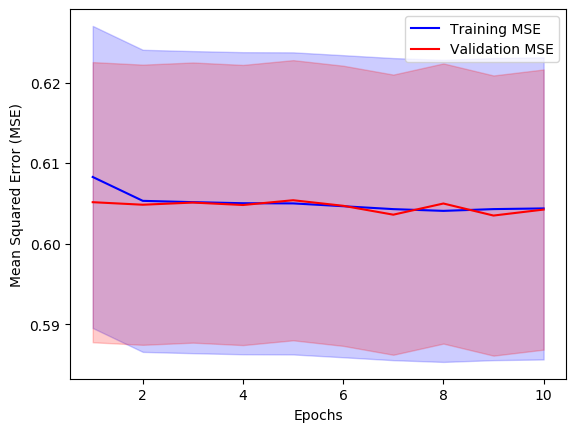

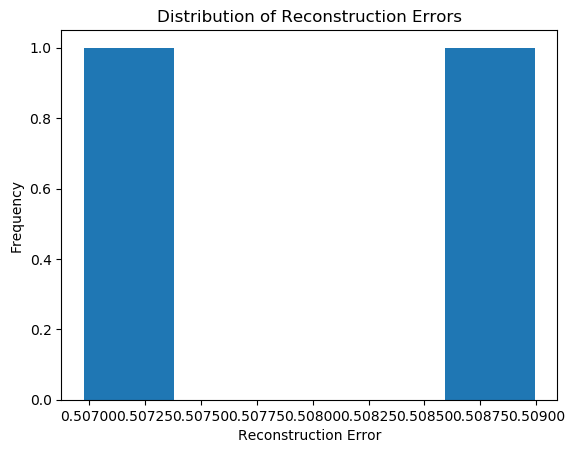

In [24]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 40
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.0003))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate
#opt = Adam(lr= 0.00874103303583597)
opt = Adam(lr= 0.0087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits,shuffle=True,random_state=18)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# plot the distribution of reconstruction errors
plt.hist(recon_errors, bins=5)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

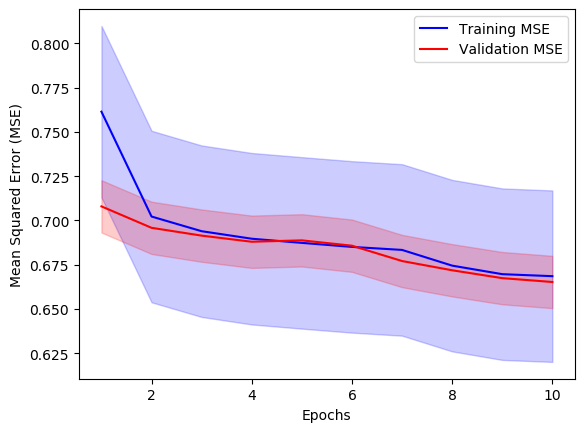

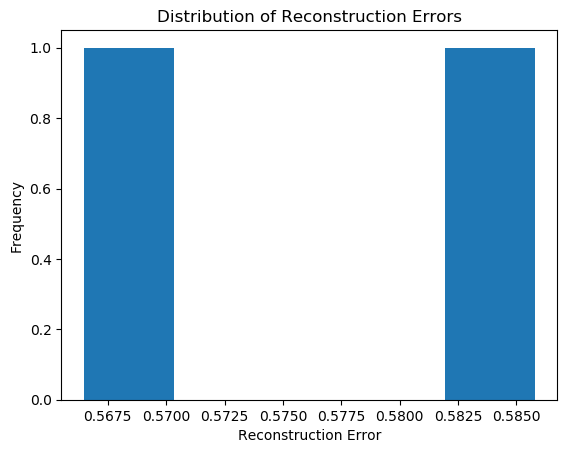

In [29]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 40
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.025))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.002)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits,shuffle=True,random_state=18)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# plot the distribution of reconstruction errors
plt.hist(recon_errors, bins=5)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.show()

In [41]:
# import matplotlib.pyplot as plt
# from keras.layers import Input, Dense
# from keras.models import Model
# from keras.optimizers import Adam
# from sklearn.model_selection import KFold
# import numpy as np
# from keras import regularizers
# from keras.callbacks import EarlyStopping

# # Define the autoencoder architecture
# input_dim = X_train_resampled_final.shape[1]
# encoding_dim = 40
# decoding_dim = 10

# input_layer = Input(shape=(input_dim,))
# #hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# # Add L1 regularization to the hidden layer
# hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.2156))(input_layer)

# output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# # Define the optimizer with the desired learning rate
# #opt = Adam(lr= 0.00874103303583597)
# opt = Adam(lr= 0.0087)
# # Define the autoencoder model
# autoencoder = Model(inputs=input_layer, outputs=output_layer)
# #autoencoder.compile(optimizer='adam', loss='mse')
# autoencoder.compile(optimizer=opt, loss='mse')

# # Define the number of folds for cross-validation
# n_splits = 2
# kf = KFold(n_splits=n_splits,shuffle=True,random_state=18)

# # Define lists to store the MSE of training and validation sets for each fold
# train_mse = []
# val_mse = []
# recon_errors = []


# # Loop over each fold
# for train_index, val_index in kf.split(X_train_resampled_final):
    
#     # Split the data into training and validation sets for the current fold
#     X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
#     early_stopping = EarlyStopping(monitor='val_loss', patience=5)

#     # Fit the autoencoder on the training set for the current fold
#     history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
#     # Append the MSE of training and validation sets for the current fold to the lists
#     train_mse.append(history.history['loss'])
#     val_mse.append(history.history['val_loss'])
    
#     # compute the reconstruction error for the test data
#     recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
#     recon_errors.append(recon_error)

# # Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# # mean_train_mse = np.mean(train_mse, axis=0)
# # std_train_mse = np.std(train_mse, axis=0)
# # mean_val_mse = np.mean(val_mse, axis=0)
# # std_val_mse = np.std(val_mse, axis=0)
# # Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# #std_train_mse = np.std(np.array(train_mse), axis=0)
# std_train_mse = np.std(np.concatenate(train_mse), axis=0)

# mean_val_mse = np.mean(val_mse, axis=0)
# #std_val_mse = np.std(np.array(val_mse), axis=0)
# std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# # Plot the MSE of training and validation sets against the number of epochs
# epochs = range(1, len(mean_train_mse)+1)
# plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
# plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
# plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
# plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
# plt.xlabel('Epochs')
# plt.ylabel('Mean Squared Error (MSE)')
# plt.legend()
# plt.show()

# # plot the distribution of reconstruction errors
# plt.hist(recon_errors, bins=5)
# plt.xlabel('Reconstruction Error')
# plt.ylabel('Frequency')
# plt.title('Distribution of Reconstruction Errors')
# plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

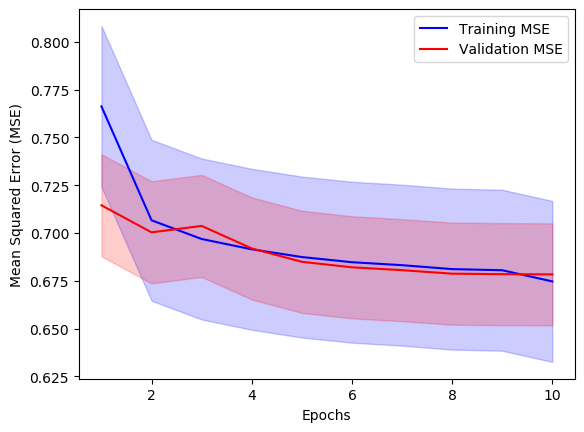

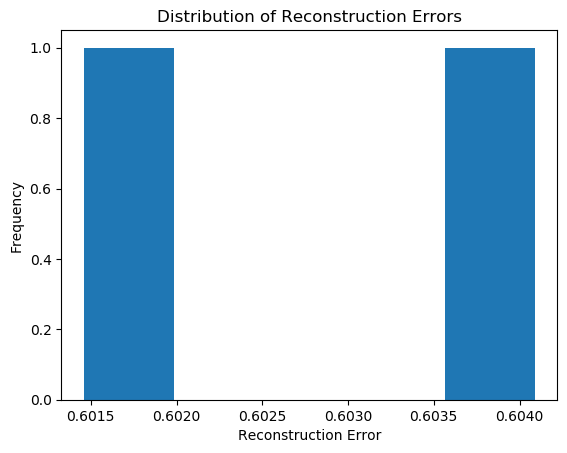

In [20]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 35
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.025))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.002)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits,shuffle=True,random_state=18)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# plot the distribution of reconstruction errors
plt.hist(recon_errors, bins=5)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

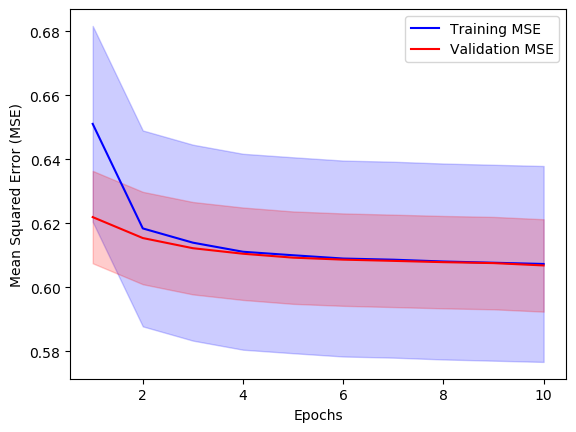

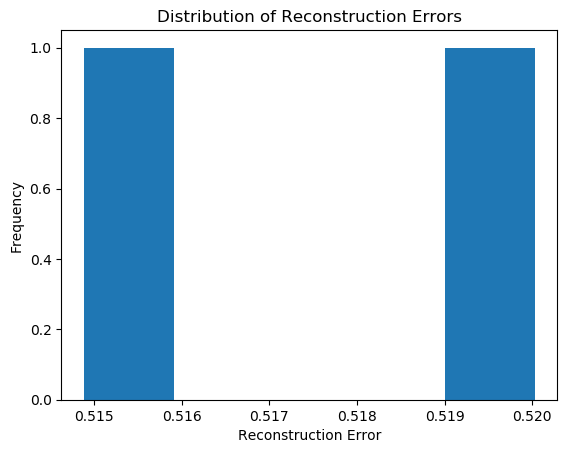

In [40]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 32
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.003))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits,shuffle=True,random_state=18)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# plot the distribution of reconstruction errors
plt.hist(recon_errors, bins=5)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

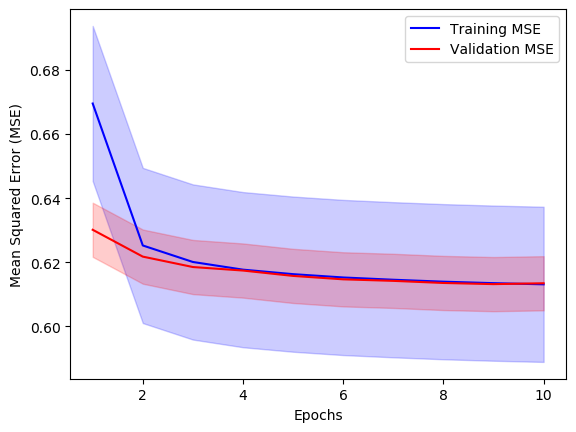

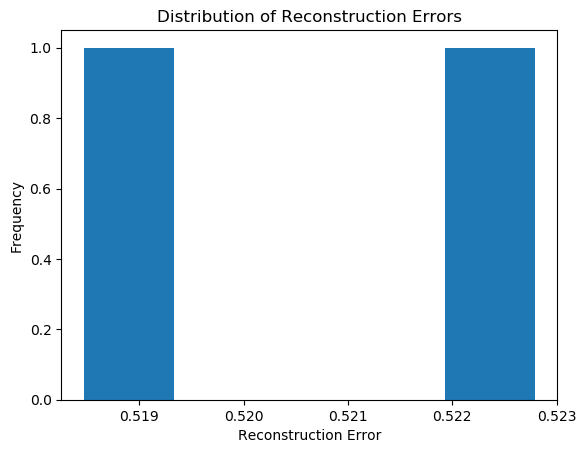

In [21]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 8
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.003))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits,shuffle=True,random_state=18)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# plot the distribution of reconstruction errors
plt.hist(recon_errors, bins=5)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.show()

## Plot autoencoder network

In [ ]:
from keras.utils import plot_model

plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image

dot = model_to_dot(autoencoder, show_shapes=True, show_layer_names=True)
Image(dot.create_png())

In [ ]:
# import matplotlib.pyplot as plt
# from keras.layers import Input, Dense
# from keras.models import Model
# from keras.optimizers import Adam
# from sklearn.model_selection import KFold
# import numpy as np
# from keras import regularizers
# from keras.callbacks import EarlyStopping

# # Define the autoencoder architecture
# input_dim = X_train_resampled_final.shape[1]
# encoding_dim = 30
# decoding_dim = 10

# input_layer = Input(shape=(input_dim,))
# #hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# # Add L1 regularization to the hidden layer
# hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.15))(input_layer)

# output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# # Define the optimizer with the desired learning rate
# opt = Adam(lr= 0.00874103303583597)

# # Define the autoencoder model
# autoencoder = Model(inputs=input_layer, outputs=output_layer)
# #autoencoder.compile(optimizer='adam', loss='mse')
# autoencoder.compile(optimizer=opt, loss='mse')

# # Define the number of folds for cross-validation
# n_splits = 2
# kf = KFold(n_splits=n_splits, random_state=42,shuffle=True)

# # Define lists to store the MSE of training and validation sets for each fold
# train_mse = []
# val_mse = []
# recon_errors = []


# # Loop over each fold
# for train_index, val_index in kf.split(X_train_resampled_final):
    
#     # Split the data into training and validation sets for the current fold
#     X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
#     early_stopping = EarlyStopping(monitor='val_loss', patience=5)

#     # Fit the autoencoder on the training set for the current fold
#     history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
#     # Append the MSE of training and validation sets for the current fold to the lists
#     train_mse.append(history.history['loss'])
#     val_mse.append(history.history['val_loss'])
    
#     # compute the reconstruction error for the test data
#     recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
#     recon_errors.append(recon_error)

# # Convert the train_mse and val_mse lists to numpy arrays
# train_mse = np.array(train_mse)
# val_mse = np.array(val_mse)

# # Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)


# # Plot the MSE of training and validation sets against the number of epochs
# epochs = range(1, len(mean_train_mse)+1)
# plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
# plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
# plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
# plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
# plt.xlabel('Epochs')
# plt.ylabel('Mean Squared Error (MSE)')
# plt.legend()
# plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

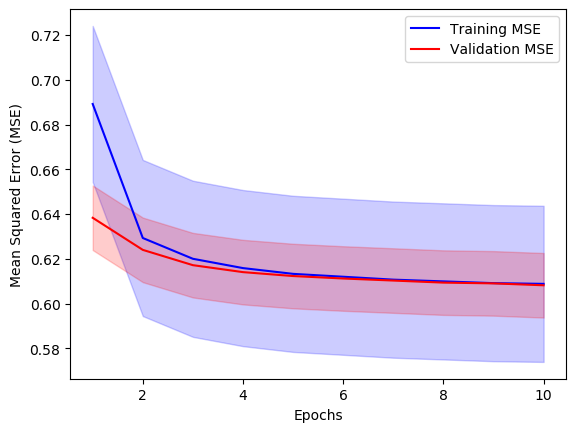

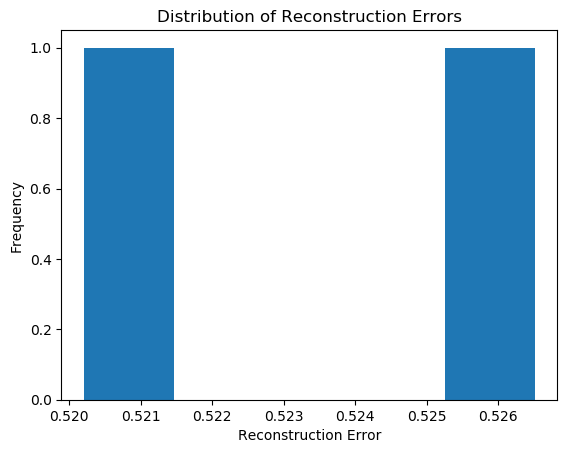

In [37]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 35
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.1))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.001)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits,shuffle=True,random_state=18)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# plot the distribution of reconstruction errors
plt.hist(recon_errors, bins=5)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

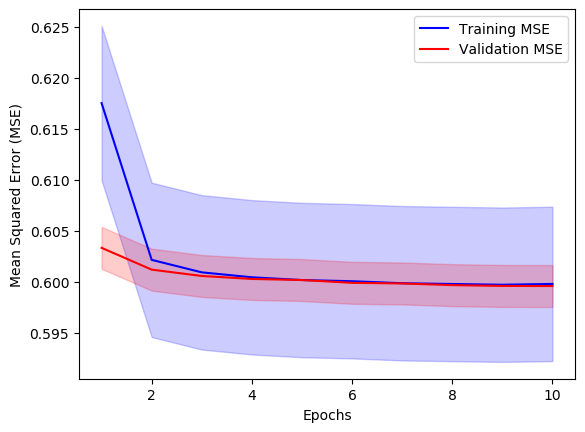

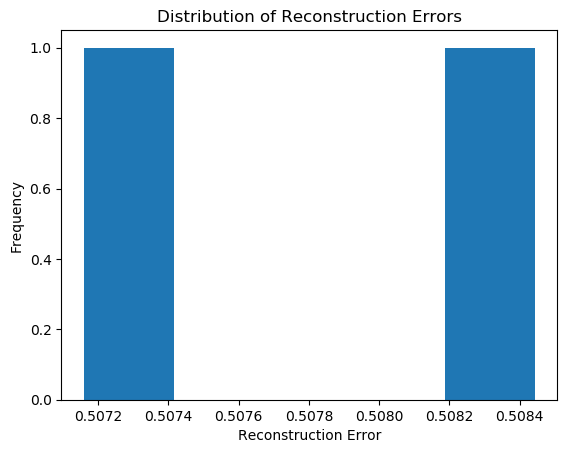

In [33]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 35
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.001)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits,shuffle=True,random_state=18)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# plot the distribution of reconstruction errors
plt.hist(recon_errors, bins=5)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

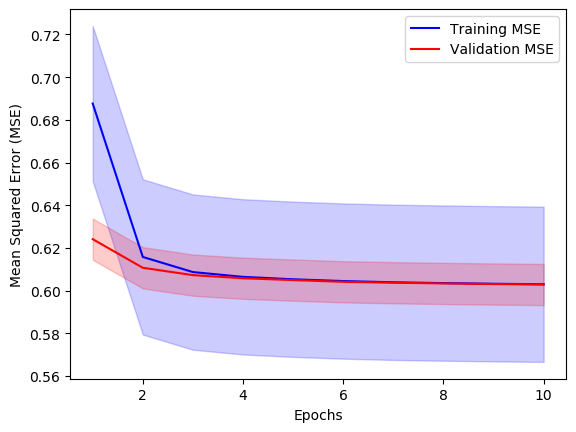

In [36]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 40
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.0001)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits,shuffle=True,random_state=18)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=7)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

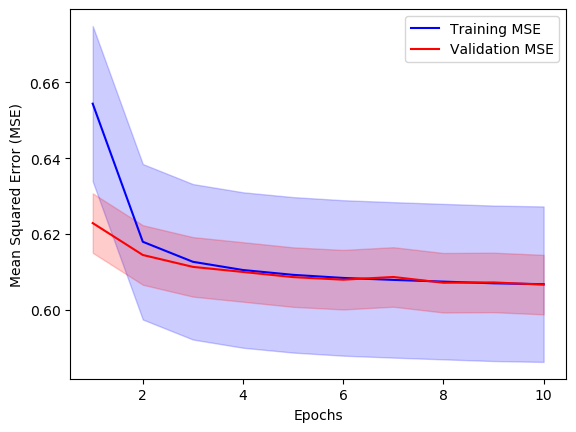

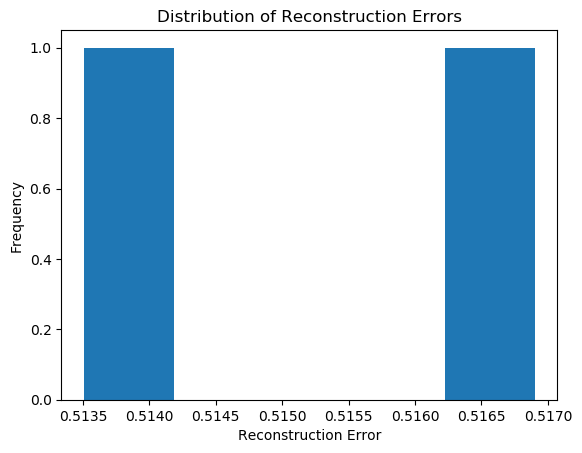

In [38]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 13
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.003))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits,shuffle=True,random_state=18)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# plot the distribution of reconstruction errors
plt.hist(recon_errors, bins=5)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

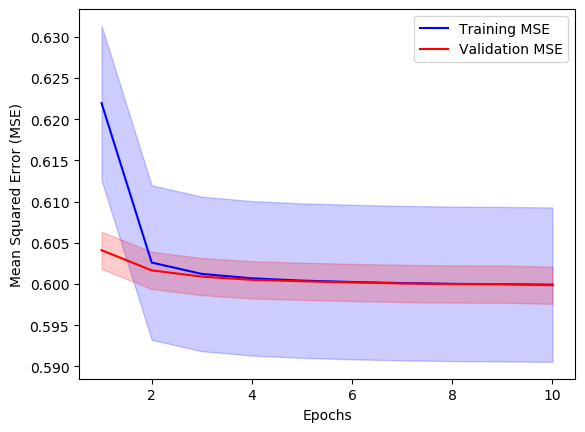

In [41]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 40
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00071)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits,shuffle=True,random_state=18)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=7)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

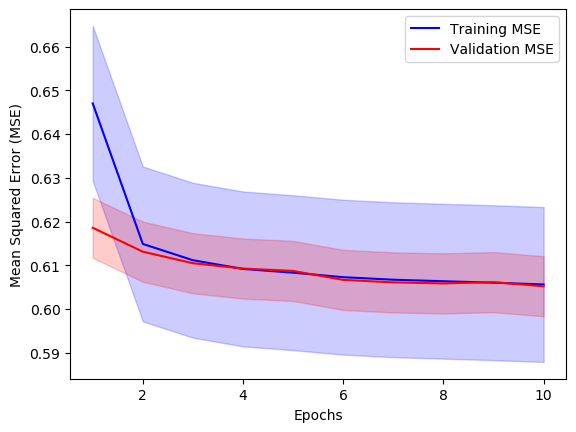

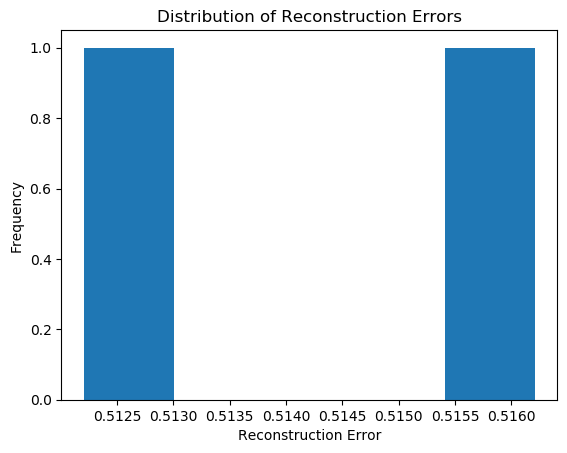

In [42]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 55
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.003))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits,shuffle=True,random_state=18)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# plot the distribution of reconstruction errors
plt.hist(recon_errors, bins=5)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

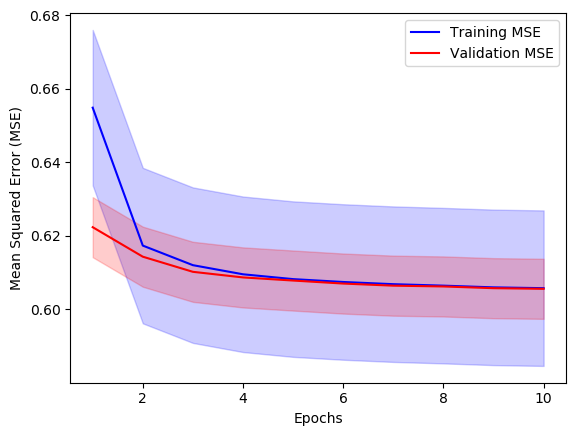

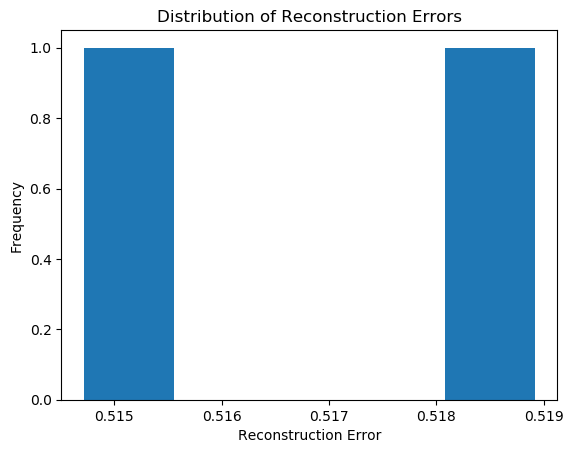

In [39]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 18
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.003))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits,shuffle=True,random_state=18)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# plot the distribution of reconstruction errors
plt.hist(recon_errors, bins=5)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

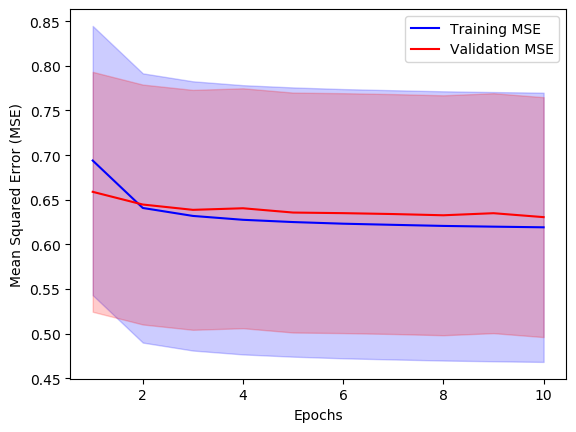

In [55]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 30
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.0095))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# # plot the distribution of reconstruction errors
# plt.hist(recon_errors, bins=5)
# plt.xlabel('Reconstruction Error')
# plt.ylabel('Frequency')
# plt.title('Distribution of Reconstruction Errors')
# plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

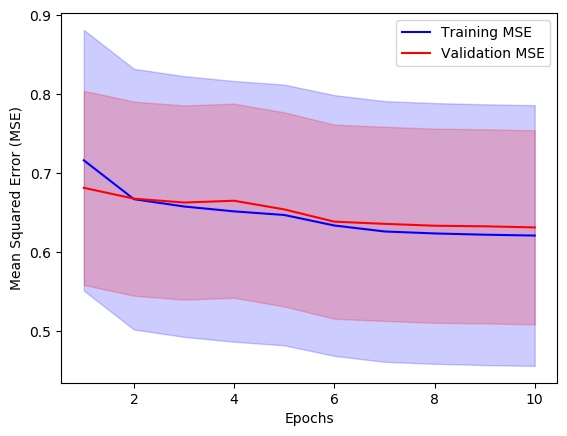

In [62]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
# Set random seed for reproducibility
np.random.seed(42)

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 10
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.00991))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# # plot the distribution of reconstruction errors
# plt.hist(recon_errors, bins=5)
# plt.xlabel('Reconstruction Error')
# plt.ylabel('Frequency')
# plt.title('Distribution of Reconstruction Errors')
# plt.show()

In [66]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
# Set random seed for reproducibility
np.random.seed(42)

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 35
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.0991))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# # plot the distribution of reconstruction errors
# plt.hist(recon_errors, bins=5)
# plt.xlabel('Reconstruction Error')
# plt.ylabel('Frequency')
# plt.title('Distribution of Reconstruction Errors')
# plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

KeyboardInterrupt: 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

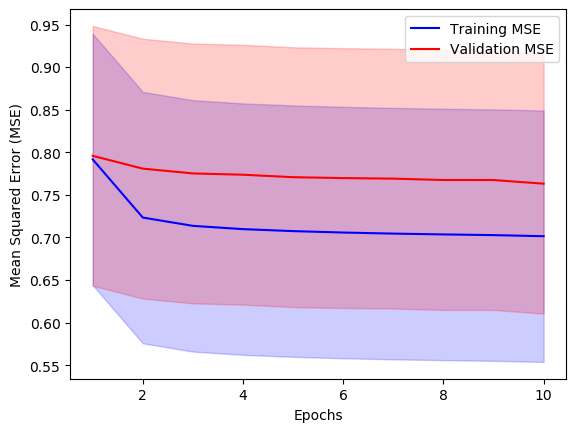

In [64]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
# Set random seed for reproducibility
np.random.seed(42)

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 4
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.00991))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# # plot the distribution of reconstruction errors
# plt.hist(recon_errors, bins=5)
# plt.xlabel('Reconstruction Error')
# plt.ylabel('Frequency')
# plt.title('Distribution of Reconstruction Errors')
# plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

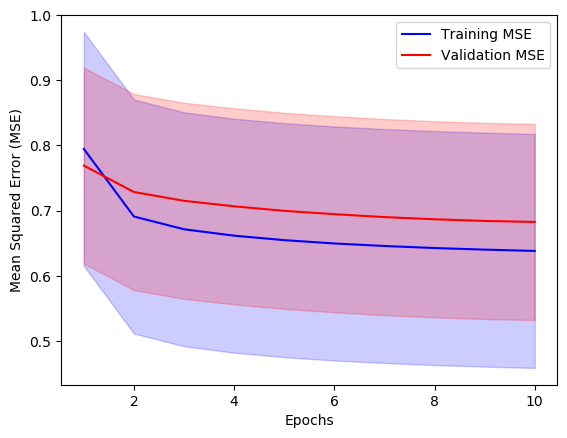

In [65]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
# Set random seed for reproducibility
np.random.seed(42)

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 10
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.00991))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=128, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# # plot the distribution of reconstruction errors
# plt.hist(recon_errors, bins=5)
# plt.xlabel('Reconstruction Error')
# plt.ylabel('Frequency')
# plt.title('Distribution of Reconstruction Errors')
# plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

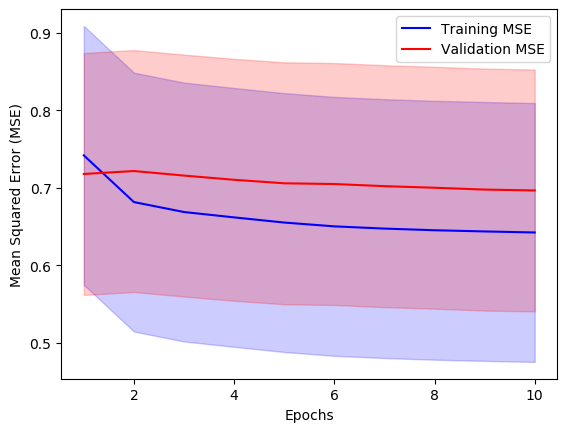

In [67]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
# Set random seed for reproducibility
np.random.seed(42)

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 4
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.00991))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# # plot the distribution of reconstruction errors
# plt.hist(recon_errors, bins=5)
# plt.xlabel('Reconstruction Error')
# plt.ylabel('Frequency')
# plt.title('Distribution of Reconstruction Errors')
# plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

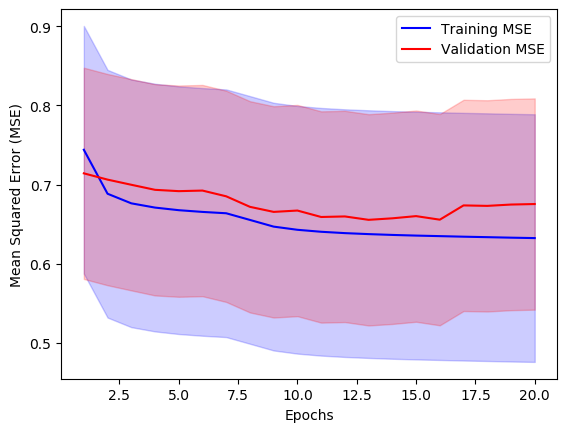

In [68]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
# Set random seed for reproducibility
np.random.seed(42)

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 4
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.00991))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=20, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# # plot the distribution of reconstruction errors
# plt.hist(recon_errors, bins=5)
# plt.xlabel('Reconstruction Error')
# plt.ylabel('Frequency')
# plt.title('Distribution of Reconstruction Errors')
# plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

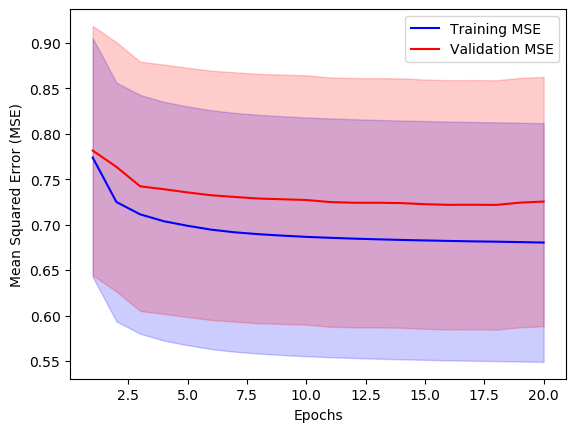

In [70]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
# Set random seed for reproducibility
np.random.seed(42)

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 4
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.00991))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=15, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# # plot the distribution of reconstruction errors
# plt.hist(recon_errors, bins=5)
# plt.xlabel('Reconstruction Error')
# plt.ylabel('Frequency')
# plt.title('Distribution of Reconstruction Errors')
# plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

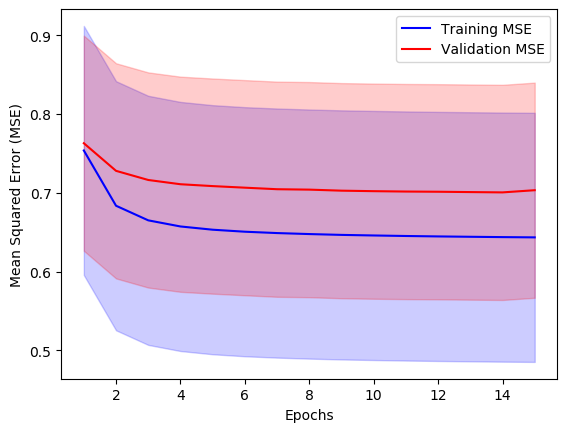

In [74]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
# Set random seed for reproducibility
np.random.seed(42)

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 4
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.00991))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=15, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# # plot the distribution of reconstruction errors
# plt.hist(recon_errors, bins=5)
# plt.xlabel('Reconstruction Error')
# plt.ylabel('Frequency')
# plt.title('Distribution of Reconstruction Errors')
# plt.show()

## MSE Test set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

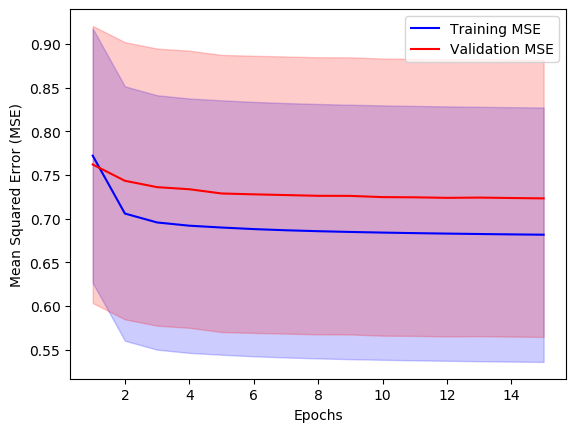

In [89]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
# Set random seed for reproducibility
np.random.seed(42)

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 4
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.00991))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
test_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=15, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)
    
    # Calculate the MSE for the test set
    test_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    test_mse.append(test_error)
    print(f"Test MSE: {test_error:.5f}")

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

## Baseline model

The baseline model is simply the mean squared error between each data point in the test set and the mean of the training set, which serves as a simple reference point for comparison to the more complex autoencoder model.

In [85]:
# Define the input shape for the autoencoder
input_shape = X_train_resampled_final.shape[1]

# Create the input layer
input_layer = Input(shape=input_shape)

# Create the encoder layer with a linear activation function and no hidden layers
encoded_layer = Dense(units=input_shape, activation='linear')(input_layer)

# Create the decoder layer with a linear activation function and no hidden layers
decoded_layer = Dense(units=input_shape, activation='linear')(encoded_layer)

# Create the autoencoder model
autoencoder_baseline = Model(input_layer, decoded_layer)

# Compile the autoencoder model with a mean squared error loss function and an Adam optimizer
autoencoder_baseline.compile(loss='mean_squared_error', optimizer='adam')

# Train the autoencoder on the training data
autoencoder_baseline.fit(X_train_resampled_final, X_train_resampled_final, epochs=1, batch_size=32, validation_data=(X_test, X_test))

# Evaluate the reconstruction error on the test set
test_predictions = autoencoder.predict(X_test)
test_mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)
baseline_mse = np.mean(np.power(X_test - np.mean(X_train_resampled_final, axis=0), 2), axis=1)

# Compare the performance of the autoencoder to the baseline
print('Autoencoder MSE:', np.mean(test_mse))
print('Baseline MSE:', np.mean(baseline_mse))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13233/13233 [==============================] - ETA: 0s - loss: 0.0468WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002198380A168> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full outp

In [56]:
autoencoder.summary()

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 10)]              0         
                                                                 
 dense_66 (Dense)            (None, 30)                330       
                                                                 
 dense_67 (Dense)            (None, 10)                310       
                                                                 
Total params: 640
Trainable params: 640
Non-trainable params: 0
_________________________________________________________________


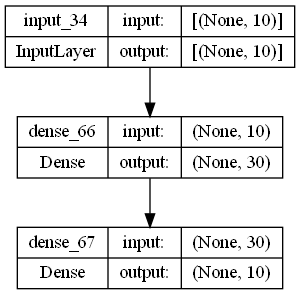

In [57]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder_new.png', show_shapes=True)

## Check if mediator network overfit

In [ ]:
# extract hidden layer output from autoencoder
hidden_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
hidden_layer_output = hidden_layer_model.predict(X_train_resampled_final)

# create the mediator network with the hidden layer output as input
mediator_input_layer = Input(shape=(encoding_dim,))
mediator_hidden_layer = Dense(10, activation='relu')(mediator_input_layer)
mediator_output_layer = Dense(2, activation='sigmoid')(mediator_hidden_layer)

mediator_network = Model(inputs=mediator_input_layer, outputs=mediator_output_layer)
mediator_network.compile(optimizer='adam', loss='mse')
mediator_network.fit(hidden_layer_output, y_train_resampled_final, epochs=1)

## Reconstruction error

In [59]:
# Load the necessary libraries
import numpy as np

# Make predictions on the test data
predictions = autoencoder.predict(X_test)

# Calculate the mean squared error between the original and reconstructed data
mse = np.mean(np.power(X_test- predictions, 2), axis=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2188/2188 [==============================] - 2s 1ms/step


In [31]:
mse

array([0.12033059, 0.32485296, 0.29190374, ..., 1.76207807, 0.28983381,
       0.32091652])

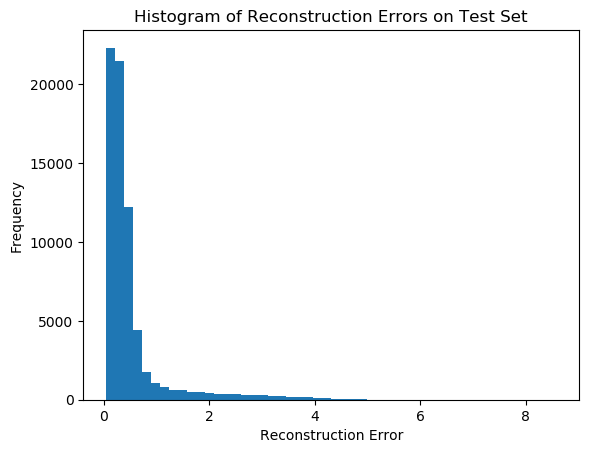

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the histogram of the MSE values
plt.hist(mse, bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Histogram of Reconstruction Errors on Test Set")
plt.show()

In [ ]:
# Define the reward function
def reward_fn(action, label):
    DF = [0,1,2]  # indices of fraud class
    DN = [81,    787,   2392,   3121,   3449]  # indices of non-fraud class
    terminal = 0  # initialize terminal flag to 0
    if label in DF:
        if action == label:
            reward = 1
        else:
            reward = -1
            terminal = 1
    else:
        if action == label:
            reward = 0.5  # set λ to 0.5
        else:
            reward = -0.5  # set λ to -0.5
    return reward, terminal

In [ ]:
# import numpy as np
# import keras
# from keras import models, layers

# # Initialize replay memory with M capacity
# M = 10000
# replay_memory = []

# # Initialize simulation environment
# env = None  # Replace with your own simulation environment

# # Define the reward function
# def reward_fn(action, label):
#     # Replace with your own reward function
#     if action == label:
#         return 1
#     else:
#         return -1

# # Define hyperparameters
# K = 2  # Number of episodes
# T = 2  # Number of timesteps per episode
# gamma = 0.9  # Discount factor
# batch_size = 32
# learning_rate = 0.001

# # Initialize agent network with same architecture as mediator network
# agent_network = keras.models.Sequential([
#     keras.layers.Dense(20, activation='relu', input_shape=(10,)),
#     keras.layers.Dense(10, activation='softmax')
# ])
# agent_network.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=learning_rate))

# # Initialize mediator network
# mediator_network = None  # Replace with your own mediator network

# # Generate dataset D
# hidden_layer_output = autoencoder.predict(X_train_resampled_final)
# D = [(hidden_layer_output[i], y_train_resampled_final[i]) for i in range(len(hidden_layer_output))]

# # Train agent
# for k in range(K):
#     # Shuffle dataset D
#     np.random.shuffle(D)
    
#     # Initialize state
#     state = D[0][0]
    
#     for t in range(T):
#         # Choose action
#         action = agent_network.predict(state.reshape(1, -1)).argmax()
        
#         # Calculate reward and terminal flag
#         reward = reward_fn(action, D[t][1])
#         terminal = 1 if t == T - 1 else 0
#         print("Reward:", reward) # Add this line to print the reward
#         print("Terminal:", terminal) # Add this line to print the terminal flag
        
#         # Update state
#         state_next = D[t+1][0] if t < T - 1 else state
        
#         # Store transition in replay memory
#         replay_memory.append((state, action, reward, state_next, terminal))
#         if len(replay_memory) > M:
#             replay_memory.pop(0)
        
#         # Sample minibatch from replay memory
#         if len(replay_memory) >= batch_size:
#             minibatch = random.sample(replay_memory, batch_size)
#         else:
#             continue

#         X = np.zeros((batch_size, 10))
#         y = np.zeros((batch_size, 10))
#         for i in range(batch_size):
#             state_i, action_i, reward_i, state_next_i, terminal_i = minibatch[i]
#             X[i] = state_i
#             y[i] = agent_network.predict(state_i.reshape(1, -1))
#             if terminal_i:
#                 y[i][action_i] = reward_i
#             else:
#                 y[i][action_i] = reward_i + gamma * np.max(agent_network.predict(state_next_i.reshape(1, -1)))
        
#         # Train agent network on minibatch
#         agent_network.train_on_batch(X, y)
        
#         # Update state
#         state = state_next
        
#         # Check if episode is over
#         if terminal:
#             break

In [ ]:
# import numpy as np
# import keras
# from keras import models, layers

# # Initialize replay memory with M capacity
# M = 10000
# replay_memory = []

# # Initialize simulation environment
# env = None  # Replace with your own simulation environment

# # Define the reward function
# def reward_fn(action, label):
#     # Replace with your own reward function
#     if action == label:
#         return 1
#     else:
#         return -1

# # Define hyperparameters
# K = 8  # Number of episodes
# T = 8  # Number of timesteps per episode
# gamma = 0.9  # Discount factor
# batch_size = 32
# learning_rate = 0.001

# # # Initialize agent network with same architecture as mediator network
# # agent_network = keras.models.Sequential([
# #     keras.layers.Dense(20, activation='relu', input_shape=(10,)),
# #     keras.layers.Dense(2, activation='softmax')
# # ])
# # agent_network.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=learning_rate))

# # #Initialize mediator network
# # mediator_network = None  # Replace with your own mediator network

# # Generate dataset D
# hidden_layer_output = autoencoder.predict(X_train_resampled_final)
# D = [(hidden_layer_output[i], y_train_resampled_final[i]) for i in range(len(hidden_layer_output))]

# # Train agent
# for k in range(K):
#     # Shuffle dataset D
#     np.random.shuffle(D)
    
#     # Initialize state
#     state = D[0][0]
    
#     for t in range(T):
#         # Choose action
#         action = agent_network.predict(state.reshape(1, -1)).argmax()
        
#         # Calculate reward and terminal flag
#         reward = reward_fn(action, D[t][1])
#         terminal = 1 if t == T - 1 else 0
#         print("Reward:", reward) # Add this line to print the reward
#         print("Terminal:", terminal) # Add this line to print the terminal flag
        
#         # Update state
#         state_next = D[t+1][0] if t < T - 1 else state
        
#         # Store transition in replay memory
#         replay_memory.append((state, action, reward, state_next, terminal))
#         if len(replay_memory) > M:
#             replay_memory.pop(0)
        
#         # Sample minibatch from replay memory
#         if len(replay_memory) >= batch_size:
#             minibatch = random.sample(replay_memory, batch_size)
#         else:
#             continue

#         X = np.zeros((batch_size, 10))
#         y = np.zeros((batch_size, 10))
#         for i in range(batch_size):
#             state_i, action_i, reward_i, state_next_i, terminal_i = minibatch[i]
#             X[i] = state_i
#             y[i] = agent_network.predict(state_i.reshape(1, -1))
#             if terminal_i:
#                 y[i][action_i] = reward_i
#             else:
#                 y[i][action_i] = reward_i + gamma * np.max(agent_network.predict(state_next_i.reshape(1, -1)))
        
#         # Train agent network on minibatch
#         agent_network.train_on_batch(X, y)
        
#         # Update state
#         state = state_next
        
#         # Check if episode is over
#         if terminal:
#             break

In [ ]:
import numpy as np
import keras
from keras import models, layers
import random

# Initialize replay memory with M capacity
M = 10000
replay_memory = []

# Initialize simulation environment
env = None  # Replace with your own simulation environment

# # Define the reward function
# def reward_fn(action, label):
#     # Replace with your own reward function
#     if action == label:
#         return 1
#     else:
#         return -1


# Define hyperparameters
K = 2  # Number of episodes
T = 2  # Number of timesteps per episode
gamma = 0.9  # Discount factor
batch_size = 32
learning_rate_val = 0.001

mediator_network = keras.models.Sequential([
    keras.layers.Dense(20, activation='relu', input_shape=(10,)),
    keras.layers.Dense(10, activation='softmax')
])
mediator_network.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=learning_rate_val))


# Generate dataset D
# X_train_resampled_final_20 = np.hstack((X_train_resampled_final, np.zeros((X_train_resampled_final.shape[0], 10))))
# hidden_layer_output = [mediator_network.predict(np.array([x]*2).reshape(2, -1))[0] for x in X_train_resampled_final]
# D = [(hidden_layer_output[i], y_train_resampled_final[i]) for i in range(len(hidden_layer_output))]

hidden_layer_output = mediator_network.predict(X_train_resampled_final)
D = [(hidden_layer_output[i], y_train_resampled_final[i]) for i in range(len(hidden_layer_output))]

# Train agent
for k in range(K):
    # Shuffle dataset D
    np.random.shuffle(D)
    
    # Initialize state
    state = D[0][0]
    
    for t in range(T):
        # Choose action
        action = agent_network.predict(state.reshape(1, -1)).argmax()
        
        # Calculate reward and terminal flag
        reward = reward_fn(action, D[t][1])
        terminal = 1 if t == T - 1 else 0
        print("Reward:", reward) # Add this line to print the reward
        print("Terminal:", terminal) # Add this line to print the terminal flag
        
        # Update state
        state_next = D[t+1][0] if t < T - 1 else state
        
        # Store transition in replay memory
        replay_memory.append((state, action, reward, state_next, terminal))
        if len(replay_memory) > M:
            replay_memory.pop(0)
        
        # Sample minibatch from replay memory
        if len(replay_memory) >= batch_size:
            minibatch = random.sample(replay_memory, batch_size)
        else:
            continue

        X = np.zeros((batch_size, 10))
        y = np.zeros((batch_size, 10))
        for i in range(batch_size):
            state_i, action_i, reward_i, state_next_i, terminal_i = minibatch[i]
            X[i] = state_i
            y[i] = agent_network.predict(state_i.reshape(1, -1))
            if terminal_i:
                y[i][action_i] = reward_i
            else:
                y[i][action_i] = reward_i + gamma * np.max(agent_network.predict(state_next_i.reshape(1, -1)))
        
        # Train agent network on minibatch - CONCEPT OF GRADIENT DESCENT
        agent_network.train_on_batch(X, y)
        
        # Update state
        state = state_next
        
        # Check if episode is over
        if terminal:
            break

In [ ]:
import numpy as np
import keras
from keras import models, layers
import random

# Initialize replay memory with M capacity
M = 10000
replay_memory = []

# Initialize simulation environment
env = None  # Replace with your own simulation environment

# # Define the reward function
# def reward_fn(action, label):
#     # Replace with your own reward function
#     if action == label:
#         return 1
#     else:
#         return -1

# Define policy
def policy(state, model):
    q_values = model.predict(state)
    return np.argmax(q_values[0])

# Define hyperparameters
K = 2  # Number of episodes
T = 2  # Number of timesteps per episode
gamma = 0.9  # Discount factor
batch_size = 32
learning_rate_val = 0.001

mediator_network = keras.models.Sequential([
    keras.layers.Dense(20, activation='relu', input_shape=(10,)),
    keras.layers.Dense(10, activation='softmax')
])
mediator_network.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=learning_rate_val))


# Generate dataset D
# X_train_resampled_final_20 = np.hstack((X_train_resampled_final, np.zeros((X_train_resampled_final.shape[0], 10))))
# hidden_layer_output = [mediator_network.predict(np.array([x]*2).reshape(2, -1))[0] for x in X_train_resampled_final]
# D = [(hidden_layer_output[i], y_train_resampled_final[i]) for i in range(len(hidden_layer_output))]

hidden_layer_output = mediator_network.predict(X_train_resampled_final)
D = [(hidden_layer_output[i], y_train_resampled_final[i]) for i in range(len(hidden_layer_output))]

# Train agent
for k in range(K):
    # Shuffle dataset D
    np.random.shuffle(D)
    
    # Initialize state
    state = D[0][0]
    
    for t in range(T):
        # Choose action based on policy
        action = policy(state.reshape(1, -1), agent_network)
        
        # Calculate reward and terminal flag
        reward = reward_fn(action, D[t][1])
        terminal = 1 if t == T - 1 else 0
        print("Reward:", reward) # Add this line to print the reward
        print("Terminal:", terminal) # Add this line to print the terminal flag
        
        # Update state
        state_next = D[t+1][0] if t < T - 1 else state
        
        # Store transition in replay memory
        replay_memory.append((state, action, reward, state_next, terminal))
        if len(replay_memory) > M:
            replay_memory.pop(0)
        
        # Sample minibatch from replay memory
        if len(replay_memory) >= batch_size:
            minibatch = random.sample(replay_memory, batch_size)
        else:
            continue

        X = np.zeros((batch_size, 10))
        y = np.zeros((batch_size, 10))
        for i in range(batch_size):
            state_i, action_i, reward_i, state_next_i, terminal_i = minibatch[i]
            X[i] = state_i
            y[i] = agent_network.predict(state_i.reshape(1, -1))
            if terminal_i:
                y[i][action_i] = reward_i
            else:
                y[i][action_i] = reward_i + gamma * np.max(agent_network.predict(state_next_i.reshape(1, -1)))
                    mediator_network.train_on_batch(X, y)
    
        # Update state
        state = state_next

        # Check if episode is over
        if terminal:
            break

# Evaluate policy πθ
rewards = []
for i in range(len(D)):
    state = D[i][0]
    label = D[i][1]
    action_probs = mediator_network.predict(np.array([state]*10).reshape(10, -1))
    action = np.argmax(action_probs)
    reward = reward_fn(action, label)
    rewards.append(reward)
print("Average reward:", np.mean(rewards)) # Add this line to print the average reward

In [ ]:
mediator_network.summary()